In [1]:
# encoding: utf-8
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt

filename = 'movebase_time.csv'
filename_husky = 'husky_poses.csv'
point_file = 'waypoint.csv'
outfile = 'date_result.csv'
outfile_mean = 'mean_out.csv'
    
df = pd.read_csv(filename)
point = pd.read_csv(point_file)
husky = pd.read_csv(filename_husky)

df = df[df.status == 3].reset_index(drop = True)   #消除状态标志不是3的数据

In [2]:
#数据的筛选，取时间戳前后0.1秒的数据进行求和平均
data = []
for i in range(len(df.time)):
    pose_temp = husky[(husky.timestamp > (df.time[i] - 0.1)) & (husky.timestamp < (df.time[i] + 0.1))]
    entry = pose_temp.mean().values
    columns_index = pose_temp.mean().index
    data.append(entry)
    
df_1 = pd.DataFrame(data, columns = columns_index) 

In [3]:

#对获取的数据进行筛选，去到达目标点的第一个时刻的数据
temp_x = df_1.x[0]
temp_y = df_1.y[0]
pose = []
pose.append([df_1.timestamp[0], df_1.x[0], df_1.y[0], df_1.z[0], df_1.yaw[0], df_1.roll[0], df_1.pitch[0]])
for i in range(len(df_1.x) - 1):
    if ((df_1.x[i] - temp_x)**2 + (df_1.y[i] - temp_y)**2)**0.5 < 1:
        continue
    else:
        temp_x = df_1.x[i]
        temp_y = df_1.y[i]
        pose.append([df_1.timestamp[i], df_1.x[i], df_1.y[i], df_1.z[i], df_1.yaw[i], df_1.roll[i], df_1.pitch[i]])

In [4]:


list_1 = ['timestamp', 'x','y','z','yaw','roll','pitch']
df_1 = pd.DataFrame(pose, columns = list_1)  #获取数据
df_2 = df_1.drop(['timestamp'], axis = 1)  #消除时间戳的信息，与waypoint.csv文件格式一致，用于对比

times = len(df_2)//len(point)
re = len(df_2)%len(point)

point_sum = point
for i in range(times - 1):
    point_sum = point_sum.append(point).reset_index().drop(['index'], axis = 1)
point_sum = point_sum.append(point[0:re]).reset_index().drop(['index'], axis = 1)

# df_2.loc[15] = [3.18, 5.44, 0.37, 3.14, 0, 0]
df_2 = df_2[:20].append(df_2[21:]).reset_index().drop(['index'], axis = 1)#修补缺失的一个点
df_2 = df_2[:44]


erro = df_2 - point_sum



In [5]:
point_sum.head()

,x,y,z,yaw,roll,pitch
0,7.671066,8.078538,0.173143,-1.506045,0.001568,-0.017040
1,7.092567,2.389081,0.179042,3.115630,-0.002661,-0.010102
2,4.643883,2.316416,0.183047,-3.130161,-0.003340,-0.008888
3,2.203336,2.324179,0.186508,-3.076821,0.005532,-0.013075
4,3.063080,5.102489,0.175715,-0.030267,-0.002311,-0.007718


In [6]:
erro['timestamp'] = df_1.timestamp

erro = erro.reindex(columns=list_1)
# print(erro)
test = df_1.diff(1)

## 获取机器人运动轨迹的距离

husky_dis = husky[(husky.timestamp > erro.timestamp[0]) & (husky.timestamp < erro.timestamp[len(erro)-1])]
# husky_dis = husky_dis[husky_dis.timestamp < erro.timestamp[len(erro)-1]]
husky_dis = husky_dis.reset_index().drop('index', axis = 1)

list_1 = ['timestamp', 'x', 'y']
husky_dis = husky_dis.reindex(columns=list_1)

In [7]:
husky_sqr = husky_dis.diff(1).reset_index().drop(['index','timestamp'], axis = 1)
husky_sqr['sqr'] = (husky_sqr.x**2 + husky_sqr.y**2)**0.5
husky_sqr['timestamp'] = husky_dis.timestamp

rts_dis = []
for i in range(len(erro)-1):
    temp_sqr = husky_sqr[(husky_sqr.timestamp > erro.timestamp[i]) & (husky_sqr.timestamp < erro.timestamp[i+1])]
    rts_dis.append(temp_sqr.sqr.sum())
rts_dis.insert(0,np.nan)

##

erro['time'] = test.timestamp
erro['dist'] = rts_dis
erro['vel'] = erro['dist'] / erro['time']
erro.to_csv(outfile, index = False)

In [8]:

## 获取均值

index_ls = ['p1-2','p2-3','p3-4','p4-5','p5-6','p6-7','p7-8','p8-9','p9-1']

#获取每个点在loop中的平均值
df_1 = erro
data_test = []
n_points = 9
for i in range(0, len(df_1), 9):
    df_temp_1 = df_1.time[i:i+9]
#     print(df_temp_1)
    df_temp_2 = df_1.dist[i:i+9]
#     print(df_temp_2)
    df_temp_3 = df_1.vel[i:i+9]
    entry = list(df_temp_1) + list(df_temp_2) + list(df_temp_3)
    data_test.append(entry)
    
columns_name = ['time_loop_'+str(i+1) for i in range(n_points)]+['dis_loop_'+str(i+1) for i in range(n_points)]+['vel_loop_'+str(i+1) for i in range(n_points)]

df_out = pd.DataFrame(data_test, columns = columns_name)

list_mean = list(df_out.mean())
list_mean  
#获取5个loop的距离信息\

loop_mean_time = list_mean[0:9]
loop_mean_dist = list_mean[9:18]
loop_mean_vel = list_mean[18:]

mean_list = [loop_mean_time, loop_mean_dist, loop_mean_vel]
mean_out = pd.DataFrame(mean_list, columns = index_ls)
mean_out['mean'] = ['time_mean', 'dist_mean', 'vel_mean']

index_list_out = ['mean','p1-2','p2-3','p3-4','p4-5','p5-6','p6-7','p7-8','p8-9','p9-1']
mean_out.reindex(columns = index_list_out)
mean_out.to_csv(outfile_mean, index = False)



In [9]:
# plt.plot(index_ls, loop_mean_time, '*')
# plt.xlabel('waypoints')
# plt.ylabel('mean_time m/s')
# plt.title('mean_time for 5 loops')
# plt.savefig('./mean_time.jpg', dpi = 900, bbox_inches = 'tight')
# plt.show()

# plt.plot(index_ls, loop_mean_dist, '*')
# plt.xlabel('waypoints')
# plt.ylabel('mean_dist m/s')
# plt.title('mean_time for 5 loops')
# plt.savefig('./mean_dist.jpg', dpi = 900, bbox_inches = 'tight')
# plt.show()

# plt.plot(index_ls, loop_mean_time, '*')
# plt.xlabel('waypoints')
# plt.ylabel('loop_mean_vel m/s')
# plt.title('mean_vel for 5 loops')
# plt.savefig('./mean_vel.jpg', dpi = 900, bbox_inches = 'tight')
# plt.show()

##


#获取9个位置点之间的实际距离（两点间的直线距离）
real_dis = point.append(point[0:1]).reset_index().drop(['index'], axis = 1)
real_dis = real_dis.diff(1).shift(-1)[0:9]
real_dis['dis'] = (real_dis.x**2 + real_dis.y**2)**0.5

In [10]:
real_dis

,x,y,z,yaw,roll,pitch,dis
0,-0.578499,-5.689458,0.005899,4.621675,-0.004228,0.006938,5.718793
1,-2.448684,-0.072665,0.004005,-6.245791,-0.000679,0.001214,2.449762
2,-2.440547,0.007764,0.003462,0.053339,0.008872,-0.004186,2.440559
3,0.859744,2.778309,-0.010793,3.046554,-0.007843,0.005357,2.908292
4,2.271261,0.008467,-0.000705,0.010055,-0.013027,-0.003117,2.271277
5,1.540537,-0.147334,-0.000340,-0.043702,0.015746,0.015155,1.547566
6,-4.157088,0.039275,0.002032,3.084584,0.001605,-0.019187,4.157274
7,0.409913,3.330487,-0.007261,-3.052642,-0.007578,0.015999,3.355618
8,4.543362,-0.254845,0.003702,-1.474073,0.007133,-0.018172,4.550504


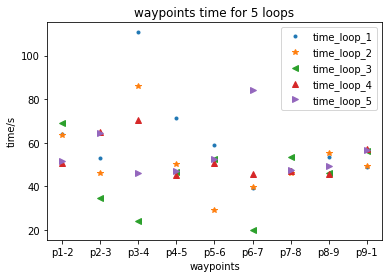

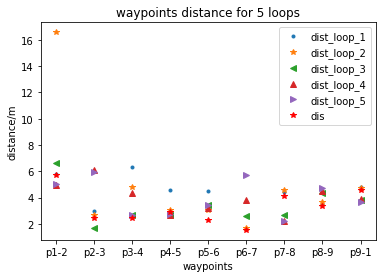

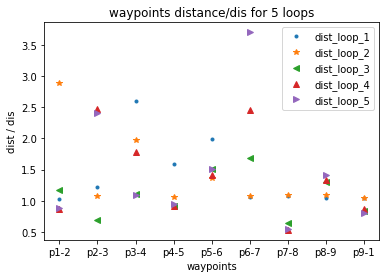

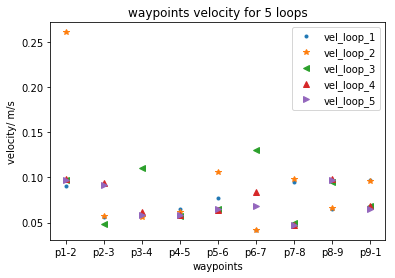

In [11]:


#获取机器人运动过程总的时间，距离，速度
list_temp = ['timestamp', 'time', 'dist', 'vel']
data_robot = erro.reindex(columns=list_temp)
data_robot = data_robot.shift(-1)[:len(data_robot)-1]

data = {'point':[1,2,3,4,5,6,7,8,9]}  #创建新的dataframe
df_robot = pd.DataFrame(data)

#获取5个loop的时间信息
df_robot['time_loop_1'] = data_robot.time[0:9].reset_index(drop = True)
df_robot['time_loop_2'] = data_robot.time[9:18].reset_index(drop = True)
df_robot['time_loop_3'] = data_robot.time[18:27].reset_index(drop = True)
df_robot['time_loop_4'] = data_robot.time[27:36].reset_index(drop = True)
df_robot['time_loop_5'] = data_robot.time[36:].reset_index(drop = True)

#获取5个loop的距离信息
df_robot['dist_loop_1'] = data_robot.dist[0:9].reset_index(drop = True)
df_robot['dist_loop_2'] = data_robot.dist[9:18].reset_index(drop = True)
df_robot['dist_loop_3'] = data_robot.dist[18:27].reset_index(drop = True)
df_robot['dist_loop_4'] = data_robot.dist[27:36].reset_index(drop = True)
df_robot['dist_loop_5'] = data_robot.dist[36:].reset_index(drop = True)

#获取5个loop的速度信息
df_robot['vel_loop_1'] = data_robot.vel[0:9].reset_index(drop = True)
df_robot['vel_loop_2'] = data_robot.vel[9:18].reset_index(drop = True)
df_robot['vel_loop_3'] = data_robot.vel[18:27].reset_index(drop = True)
df_robot['vel_loop_4'] = data_robot.vel[27:36].reset_index(drop = True)
df_robot['vel_loop_5'] = data_robot.vel[36:].reset_index(drop = True)




#画散点图，time
# plt.subplot(2,1,1)
plt.plot(index_ls, df_robot.time_loop_1, '.')
plt.plot(index_ls, df_robot.time_loop_2, '*')
plt.plot(index_ls, df_robot.time_loop_3, '<')
plt.plot(index_ls, df_robot.time_loop_4, '^')
plt.plot(index_ls, df_robot.time_loop_5, '>')

plt.xlabel('waypoints')
plt.ylabel('time/s')
plt.legend(loc = 'best')
plt.title('waypoints time for 5 loops')
plt.savefig('./time.png', dpi = 900, bbox_inches = 'tight')

plt.show()

#画散点图，dist
# plt.subplot(2,1,1)
plt.plot(index_ls, df_robot.dist_loop_1, '.')
plt.plot(index_ls, df_robot.dist_loop_2, '*')
plt.plot(index_ls, df_robot.dist_loop_3, '<')
plt.plot(index_ls, df_robot.dist_loop_4, '^')
plt.plot(index_ls, df_robot.dist_loop_5, '>')

#机器人的真实直线距离
plt.plot(index_ls, real_dis.dis, '*r')

plt.xlabel('waypoints')
plt.ylabel('distance/m')
plt.legend(loc = 'best')
plt.title('waypoints distance for 5 loops')
plt.savefig('./distance.png', dpi = 900, bbox_inches = 'tight')

plt.show()

#画散点图，dist
# plt.subplot(2,1,1)

df_robot.dist_loop_1 = df_robot.dist_loop_1/real_dis.dis
df_robot.dist_loop_2 = df_robot.dist_loop_2/real_dis.dis
df_robot.dist_loop_3 = df_robot.dist_loop_3/real_dis.dis
df_robot.dist_loop_4 = df_robot.dist_loop_4/real_dis.dis
df_robot.dist_loop_5 = df_robot.dist_loop_5/real_dis.dis

plt.plot(index_ls, df_robot.dist_loop_1, '.')
plt.plot(index_ls, df_robot.dist_loop_2, '*')
plt.plot(index_ls, df_robot.dist_loop_3, '<')
plt.plot(index_ls, df_robot.dist_loop_4, '^')
plt.plot(index_ls, df_robot.dist_loop_5, '>')

#机器人的真实直线距离
# plt.plot(df_robot.point, real_dis.dis, '*r')

plt.xlabel('waypoints')
plt.ylabel('dist / dis')
plt.legend(loc = 'best')
plt.title('waypoints distance/dis for 5 loops')
plt.savefig('./distance_dis.png', dpi = 900, bbox_inches = 'tight')

plt.show()

#画散点图，velocity
# plt.subplot(2,1,1)
plt.plot(index_ls, df_robot.vel_loop_1, '.')
plt.plot(index_ls, df_robot.vel_loop_2, '*')
plt.plot(index_ls, df_robot.vel_loop_3, '<')
plt.plot(index_ls, df_robot.vel_loop_4, '^')
plt.plot(index_ls, df_robot.vel_loop_5, '>')

plt.xlabel('waypoints')
plt.ylabel('velocity/ m/s')
plt.legend(loc = 'best')
plt.title('waypoints velocity for 5 loops')
plt.savefig('./velocity.png', dpi = 900, bbox_inches = 'tight')

plt.show()

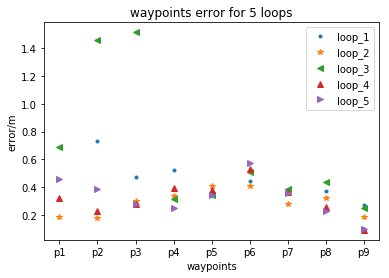

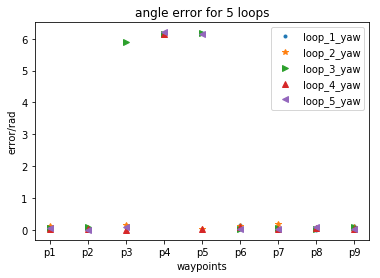

In [12]:
# encoding: utf-8
import pandas as pd
import matplotlib.pylab as plt

filename = 'date_result.csv'
outfile = 'out_plot.csv'


df = pd.read_csv(filename)

df['sq_x_y'] = (df.x**2 + df.y**2)**0.5
df_1 = df.shift(1)  #数据向后移动一行，

data = {'point':[1,2,3,4,5,6,7,8,9]}  #创建新的dataframe
df_error = pd.DataFrame(data)

df_error['loop_1'] = df_1.sq_x_y[0:9].reset_index(drop = True)
df_error['loop_2'] = df_1.sq_x_y[9:18].reset_index(drop = True)
df_error['loop_3'] = df_1.sq_x_y[18:27].reset_index(drop = True)
df_error['loop_4'] = df_1.sq_x_y[27:36].reset_index(drop = True)
df_error['loop_5'] = df_1.sq_x_y[36:].reset_index(drop = True)

df_error['loop_1_yaw'] = df_1.yaw[0:9].reset_index(drop = True)
df_error['loop_2_yaw'] = df_1.yaw[9:18].reset_index(drop = True)
df_error['loop_3_yaw'] = df_1.yaw[18:27].reset_index(drop = True)
df_error['loop_4_yaw'] = df_1.yaw[27:36].reset_index(drop = True)
df_error['loop_5_yaw'] = df_1.yaw[36:].reset_index(drop = True)

df_error.to_csv(outfile, index = False)
df_error = abs(df_error)

index_ls = ['p1','p2','p3','p4','p5','p6','p7','p8','p9']

#画散点图，点的误差
# plt.subplot(2,1,1)
plt.plot(index_ls, df_error.loop_1, '.')
plt.plot(index_ls, df_error.loop_2, '*')
plt.plot(index_ls, df_error.loop_3, '<')
plt.plot(index_ls, df_error.loop_4, '^')
plt.plot(index_ls, df_error.loop_5, '>')

plt.xlabel('waypoints')
plt.ylabel('error/m')

plt.legend(loc = 'best')
plt.title('waypoints error for 5 loops')
plt.savefig('./point_erro.png', dpi = 900, bbox_inches = 'tight')

plt.show()

#画散点图，角度的误差
# plt.subplot(2,1,2)
plt.plot(index_ls, df_error.loop_1_yaw, '.')
plt.plot(index_ls, df_error.loop_2_yaw, '*')
plt.plot(index_ls, df_error.loop_3_yaw, '>')
plt.plot(index_ls, df_error.loop_4_yaw, '^')
plt.plot(index_ls, df_error.loop_5_yaw, '<')

plt.xlabel('waypoints')
plt.ylabel('error/rad')
plt.legend(loc = 'best')
plt.title('angle error for 5 loops')

plt.savefig('./yaw_erro.png', dpi = 900, bbox_inches = 'tight')

# plt.savefig('./result.png', dpi = 1600, bbox_inches = 'tight')

plt.show()

